In [2]:
import os

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import keras.backend as K
from keras.datasets import mnist
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.initializers import *
from keras.utils.generic_utils import Progbar

In [ ]:
GPU = "0"
RUN = '10'
OUT_DIR = 'out/' + RUN
TENSORBOARD_DIR = '/tensorboard/wgans/' + RUN

In [5]:
# latent vector size
Z_SIZE = 100

# number of iterations D is trained for per each G iteration
D_ITERS = 5

EPOCHS = 100
BATCH_SIZE = 100

In [4]:
# use specific GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = GPU

In [ ]:
if not os.path.isdir(OUT_DIR): os.makedirs(OUT_DIR)

In [7]:
np.random.seed(777)

In [8]:
K.set_image_dim_ordering('tf')

In [9]:
# basically return mean(y_pred),
# but with ability to inverse it for minimization (when y_true == -1)
def wasserstein_dist(y_true, y_pred):
    return K.mean(y_true * y_pred)

In [10]:
def create_D():

    # weights are initlaized from normal distribution with below params
    weight_init = RandomNormal(mean=0., stddev=0.02)

    input_image = Input(shape=(28, 28, 1), name='input_image')

    x = Conv2D(
        32, (3, 3),
        padding='same',
        name='conv_1',
        kernel_initializer=weight_init)(input_image)
    x = LeakyReLU()(x)
    x = MaxPool2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(
        64, (3, 3),
        padding='same',
        name='conv_2',
        kernel_initializer=weight_init)(x)
    x = MaxPool2D(pool_size=1)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Conv2D(
        128, (3, 3),
        padding='same',
        name='conv_3',
        kernel_initializer=weight_init)(x)
    x = MaxPool2D(pool_size=2)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Conv2D(
        256, (3, 3),
        padding='same',
        name='coonv_4',
        kernel_initializer=weight_init)(x)
    x = MaxPool2D(pool_size=1)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    features = Flatten()(x)

    output_is_fake = Dense(
        1, activation='linear', name='output_is_fake')(features)

    output_class = Dense(
        10, activation='softmax', name='output_class')(features)

    return Model(
        inputs=[input_image], outputs=[output_is_fake, output_class], name='D')

In [11]:
def create_G(Z_SIZE=Z_SIZE):
    DICT_LEN = 10
    EMBEDDING_LEN = Z_SIZE

    # weights are initlaized from normal distribution with below params
    weight_init = RandomNormal(mean=0., stddev=0.02)

    # class#
    input_class = Input(shape=(1, ), dtype='int32', name='input_class')
    # encode class# to the same size as Z to use hadamard multiplication later on
    e = Embedding(
        DICT_LEN, EMBEDDING_LEN,
        embeddings_initializer='glorot_uniform')(input_class)
    embedded_class = Flatten(name='embedded_class')(e)

    # latent var
    input_z = Input(shape=(Z_SIZE, ), name='input_z')

    # hadamard product
    h = multiply([input_z, embedded_class], name='h')

    # cnn part
    x = Dense(1024)(h)
    x = LeakyReLU()(x)

    x = Dense(128 * 7 * 7)(x)
    x = LeakyReLU()(x)
    x = Reshape((7, 7, 128))(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, (5, 5), padding='same', kernel_initializer=weight_init)(x)
    x = LeakyReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, (5, 5), padding='same', kernel_initializer=weight_init)(x)
    x = LeakyReLU()(x)

    x = Conv2D(
        1, (2, 2),
        padding='same',
        activation='tanh',
        name='output_generated_image',
        kernel_initializer=weight_init)(x)

    return Model(inputs=[input_z, input_class], outputs=x, name='G')

In [12]:
# with tf.device('/gpu:0'):

D = create_D()

D.compile(
    optimizer=RMSprop(lr=0.00005),
    loss=[wasserstein_dist, 'sparse_categorical_crossentropy'])

In [13]:
input_z = Input(shape=(Z_SIZE, ), name='input_z_')
input_class = Input(shape=(1, ),name='input_class_', dtype='int32')

In [14]:
# with tf.device('/gpu:0'):

G = create_G()

# create combined D(G) model
# D.trainable = False
output_is_fake, output_class = D(G(inputs=[input_z, input_class]))
DG = Model(inputs=[input_z, input_class], outputs=[output_is_fake, output_class])
DG.get_layer('D').trainable = False # freeze D in generator training faze

DG.compile(
    optimizer=RMSprop(lr=0.00005),
    loss=[wasserstein_dist, 'sparse_categorical_crossentropy']
)

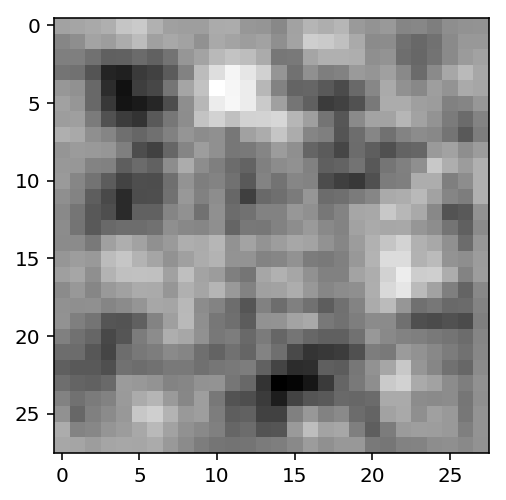

In [15]:
# try generating image
z = np.random.randn(100).reshape(1, 100)
img = G.predict([z, np.array([8])])
plt.imshow(img.reshape((28, 28)), cmap=plt.cm.gray)

In [16]:
# get our mnist data, and force it to be of shape (..., 28, 28, 1) with
# range [-1., 1.]
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)

X_test = (X_test.astype(np.float32) - 127.5) / 127.5
X_test = np.expand_dims(X_test, axis=3)

In [17]:
train_num_samples, test_num_samples = X_train.shape[0], X_test.shape[0]

In [18]:
train_history = defaultdict(list)
test_history = defaultdict(list)

In [ ]:
def save_generated_samples(epoch):

    # new batch of z's
    zz = np.random.normal(0., 1., (100, Z_SIZE))

    # new batch of classes [0..9]
    generated_classes = np.array(list(range(0, 10)) * 10, dtype=np.int32)

    generated_images = G.predict([zz, generated_classes.reshape(-1, 1)])

    rr = []
    for c in range(10):
        rr.append(
            np.concatenate(generated_images[c * 10:(1 + c) * 10]).reshape(
                280, 28))
    img = np.hstack(rr)

    plt.imsave(OUT_DIR + '/generated-e%d.png' % epoch, img, cmap=plt.cm.gray)

In [ ]:
# fake = 1
# real = -1

for epoch in range(EPOCHS):

    print('\nEpoch {} / {}:'.format(epoch + 1, EPOCHS))

    batches_num = int(train_num_samples / BATCH_SIZE)
    progress_bar = Progbar(target=batches_num)

    epoch_DG_losses = []
    epoch_D1_losses = []
    epoch_D2_losses = []

    for batch_i in range(batches_num):

        if len(epoch_D1_losses) > 0:
            progress_bar.update(
                batch_i,
                values=[
                        ('D1_is_fake', np.mean(epoch_D1_losses[-5:], axis=0)[1]),
                        ('D1_class', np.mean(epoch_D1_losses[-5:], axis=0)[2]),
                        ('D2_is_fake', np.mean(epoch_D2_losses[-5:], axis=0)[1]),
                        ('D2_class', np.mean(epoch_D2_losses[-5:], axis=0)[2]),
                        ('D(G)_is_fake', np.mean(epoch_DG_losses[-5:],axis=0)[1]),
                        ('D(G)_class', np.mean(epoch_DG_losses[-5:],axis=0)[2])
                ]
            )
        else:
            progress_bar.update(batch_i)
            
        # 1: train D on real+generated images
        
        if batch_i < 25 or batch_i % 500 == 0:
            d_iters = 100
        else:
            d_iters = D_ITERS
        
        for d_it in range(d_iters):
            
            D.trainable = True
            for l in D.layers: l.trainable = True

            # clip D weights

            for l in D.layers:
                weights = l.get_weights()
                weights = [np.clip(w, -0.01, 0.01) for w in weights]
                l.set_weights(weights)

            # 1.1: maximize D output on reals === minimize -1*(D(real))
            real_images = X_train[batch_i * BATCH_SIZE:(batch_i + 1) * BATCH_SIZE]
            real_images_classes = y_train[batch_i * BATCH_SIZE:(batch_i + 1) * BATCH_SIZE]
            
            D_loss = D.train_on_batch(real_images, [-np.ones(BATCH_SIZE), real_images_classes])
            epoch_D1_losses.append(D_loss)

            # 1.2: minimize D output on fakes 

            zz = np.random.normal(0., 1., (BATCH_SIZE, Z_SIZE))
            generated_classes = np.random.randint(0, 10, BATCH_SIZE)
            generated_images = G.predict([zz, generated_classes.reshape(-1, 1)])
            
            D_loss = D.train_on_batch(generated_images, [np.ones(BATCH_SIZE), generated_classes])
            epoch_D2_losses.append(D_loss)
            
        # 2: train D(G) (D is frozen)
        # minimize D output while supplying it with fakes, telling it that they are reals (-1)

        D.trainable = False
        for l in D.layers: l.trainable = False
        
        zz = np.random.normal(0., 1., (BATCH_SIZE, Z_SIZE)) 
        generated_classes = np.random.randint(0, 10, BATCH_SIZE)

        DG_loss = DG.train_on_batch(
            [zz, generated_classes.reshape((-1, 1))],
            [-np.ones(BATCH_SIZE), generated_classes])
        
        epoch_DG_losses.append(DG_loss)
    
    save_generated_samples(epoch)


Epoch 1 / 100
599/600 [============================>.] - ETA: 0s - D1_is_fake: -68.5461 - D1_class: 1.6644 - D2_is_fake: 44.1182 - D2_class: 2.5012 - D(G)_is_fake: -40.8354 - D(G)_class: 2.4842
Epoch 2 / 100
599/600 [============================>.] - ETA: 0s - D1_is_fake: -19.4639 - D1_class: 1.6362 - D2_is_fake: 17.2079 - D2_class: 2.4188 - D(G)_is_fake: -15.6331 - D(G)_class: 2.4056
Epoch 3 / 100
599/600 [============================>.] - ETA: 0s - D1_is_fake: -6.2792 - D1_class: 1.5616 - D2_is_fake: 4.0109 - D2_class: 2.3794 - D(G)_is_fake: -3.4337 - D(G)_class: 2.3597
Epoch 4 / 100
599/600 [============================>.] - ETA: 0s - D1_is_fake: -12.0242 - D1_class: 1.3020 - D2_is_fake: 10.9094 - D2_class: 2.3978 - D(G)_is_fake: -10.0335 - D(G)_class: 2.3683
Epoch 5 / 100
599/600 [============================>.] - ETA: 0s - D1_is_fake: -4.2000 - D1_class: 1.2238 - D2_is_fake: 3.2507 - D2_class: 2.3860 - D(G)_is_fake: -2.7847 - D(G)_class: 2.3629
Epoch 6 / 100
599/600 [============